# Reinforcement learning agent in the Cart Pole environment

## Environment Description

### Actions
- Type: ndarray (1,)
- Values: {0, 1}
- Description: The direction to push the cart (0 = left, 1 = right).

### Observation
- Type: ndarray (4,)
- Values: [cart position, cart velocity, pole angle, pole angular velocity]

### Reward
- Type: float
- Description: Reward is given for every step taken, including the termination step. Each step 
provides a reward of +1.

### Termination and Truncation
- Type: bool
- Conditions for Termination:
    - Pole Angle exceeds ±12°
    - Cart Position exceeds ±2.4 (i.e., the center of the cart reaches the edge of the display)
    - Episode length is greater than 500

In [1]:
import imageio
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

## Environment

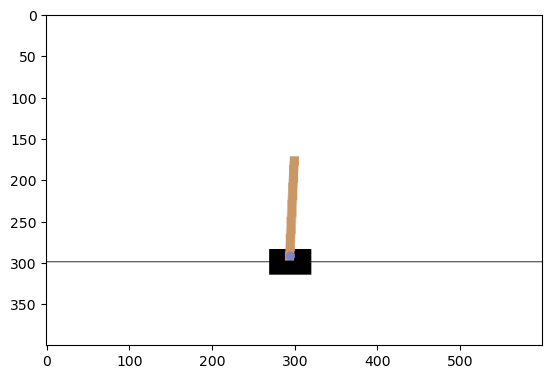

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

_ = environment.reset()
_ = plt.imshow(environment.render())

## Agent

In [3]:
import torch
import torch.nn as nn

class Agent(nn.Module):
    def __init__(self, discount=0.99):
        """Simple Agent for reinforcement learning with two hidden layers."""
        super(Agent, self).__init__()
        self.discount = discount
        
        self.layer_in = nn.Linear(4, 512)
        self.layer_hidden_1 = nn.Linear(512, 256)
        self.layer_hidden_2 = nn.Linear(256, 128)
        self.layer_out = nn.Linear(128, 2)
        
        # Agent memory:
        self.observations = []
        self.actions = []
        self.rewards = []
        
    def forward(self, x):
        """
        Forward pass.
        
        Parameters
        ----------
        x : numpy.ndarray or torch.Tensor
            Observation state.
            
        Returns
        -------
        output : torch.Tensor
            Action probabilities.
        """
        _output = torch.relu(self.layer_in(x))
        _output = torch.relu(self.layer_hidden_1(_output))
        _output = torch.relu(self.layer_hidden_2(_output))
        output = self.layer_out(_output)
        
        return output
    
    def fit(self, optimizer, loss_function):
        """
        Train Agent with memory data.
        
        Parameters
        ----------
        optimizer
        loss_function
            
        Returns
        -------
        loss : float
        """
        observations = torch.stack(self.observations)
        actions = torch.tensor(self.actions, dtype=torch.int64)
        rewards = torch.tensor(self.rewards, dtype=torch.float32)
        
        # Discounted rewards:
        discounted_rewards = torch.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(len(rewards))):
            running_add = running_add * self.discount + rewards[t]
            discounted_rewards[t] = running_add
        discounted_rewards -= discounted_rewards.mean()
        discounted_rewards /= discounted_rewards.std()
        
        # Advantage:
        advantage = torch.zeros((len(rewards), 2))
        for t in range(len(rewards)):
            advantage[t, actions[t]] = discounted_rewards[t]
        
        # Loss and backpropagation:
        loss = loss_function(self(observations), advantage)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        self.observations = []
        self.actions = []
        self.rewards = []
        
        return loss.item()
    
    def append(self, observation, action, reward):
        """Append observation, action and reward to Agent memory."""
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)

## Training

In [4]:
EPISODES = STEPS = 1000
REWARD_DISCOUNT = 0.99

agent = Agent(discount=REWARD_DISCOUNT)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(agent.parameters(), lr=0.00025)

metrics = {"length": [], "loss": []}
for episode in range(EPISODES):
    
    observation, _ = environment.reset()
    observation = torch.tensor(observation, dtype=torch.float32)
    
    _length = []
    _loss = []
    step = 0
    for _ in range(STEPS):
        step += 1
        
        # Stochastic action selection:
        actions = agent(observation)
        probabilities = torch.softmax(actions, dim=-1)
        action = np.random.choice([0, 1], 1, p=probabilities.detach().numpy().ravel())[0]
        
        new_observation, reward, terminated, truncated, _ = environment.step(action)
        
        # Incentivice longer episodes, and add to Agent memory:
        reward = -10 if ((terminated or truncated) and step < 500) else step
        agent.append(observation, action, reward)

        if terminated or truncated:
            loss = agent.fit(optimizer, loss_function)
            new_observation, _ = environment.reset()
            
            _length.append(step)
            _loss.append(loss)
            step = 0
            
        observation = torch.tensor(new_observation, dtype=torch.float32)
        
    metrics["length"].append(np.mean(_length))
    metrics["loss"].append(np.mean(_loss))

    if episode % 100 == 0 or episode == EPISODES-1:
        _mean_steps = int(np.mean(metrics["length"][-99:]))
        _mean_loss = np.mean(metrics["loss"][-99:])
        print(f"Episode {episode:<7} \n"
              f" > Average time-steps: {_mean_steps:>3} \n"
              f" > Average loss: {_mean_loss:>9.6f} \n")

Episode 0       
 > Average time-steps:  39 
 > Average loss: -0.021721 
Episode 100     
 > Average time-steps: 334 
 > Average loss: -0.004417 
Episode 200     
 > Average time-steps: 422 
 > Average loss: -0.001499 
Episode 300     
 > Average time-steps: 442 
 > Average loss:  0.001081 
Episode 400     
 > Average time-steps: 372 
 > Average loss: -0.000313 
Episode 500     
 > Average time-steps: 357 
 > Average loss: -0.001380 
Episode 600     
 > Average time-steps: 441 
 > Average loss:  0.001270 
Episode 700     
 > Average time-steps: 464 
 > Average loss:  0.002050 
Episode 800     
 > Average time-steps: 488 
 > Average loss: -0.001220 
Episode 900     
 > Average time-steps: 454 
 > Average loss: -0.001028 
Episode 999     
 > Average time-steps: 500 
 > Average loss: -0.001771 


## Metrics

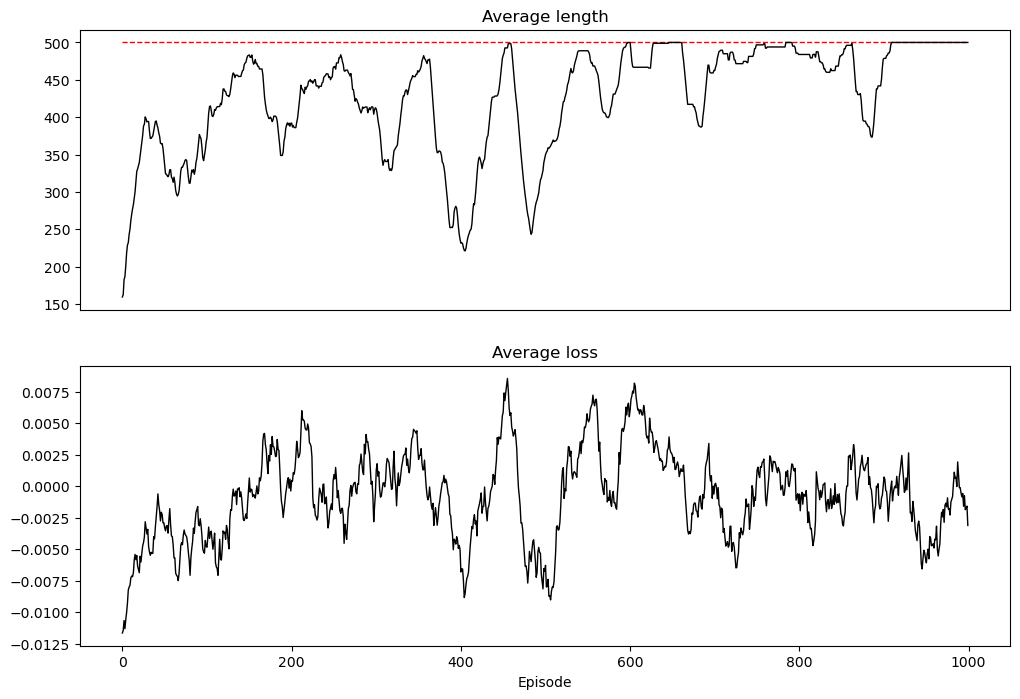

In [5]:
def moving_average(data, window_size=25):
    """Compute moving average of a list."""
    half_window = window_size // 2
    return [np.mean(data[max(0, i-half_window):min(len(data), i+half_window)]) 
            for i in range(len(data))]

lengths_smooth = moving_average(metrics["length"])
losses_smooth = moving_average(metrics["loss"])

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(range(len(metrics["length"])), [500]*len(metrics["length"]),
           color="red", linestyle="--", linewidth=1)
ax[0].plot(lengths_smooth, color="black", linewidth=1)
ax[0].set_xticks([])
ax[0].set_title("Average length")
ax[1].plot(losses_smooth, color="black", linewidth=1)
ax[1].set_xlabel("Episode")
ax[1].set_title("Average loss")

plt.show()

## Policy-based Agent in action

In [6]:
observation, _ = environment.reset()
observation = torch.tensor(observation, dtype=torch.float32)

images = []
for t in range(500):
    actions = agent(observation)
    probabilities = torch.softmax(actions, dim=-1)
    action = np.random.choice([0, 1], 1, p=probabilities.detach().numpy().ravel())[0]

    observation, reward, terminated, truncated, _ = environment.step(action)
    observation = torch.tensor(observation, dtype=torch.float32)

    images.append(environment.render())

_ = imageio.mimsave('./policy-based.gif', images, duration=50)

<img src="./policy-based.gif" width="400" height="400" />

In [7]:
environment.close()